In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import gudhi as gd
from matplotlib.pyplot import figure


# Functions

### Generating Random Point Cloud

In [2]:
def gen_points(N=5):
    # randomly generates some points in unit square
    return np.array([[rd.random(),rd.random()] for i in range(N)])


### Sublist Function

In [3]:
def k_sub(lst,k=0):
    # takes list containing a sequence of sublists and 
    # returns list of the first elements of each sublist
    return [item[k] for item in lst]

### Plot Point Cloud

In [4]:


def plot_complex(vertices, alpha=1, size=8):
    # displays NON_PERIODIC 2-dim complex
    # takes vertices as numpy array and non-empy simplex tree and plots it
    
    alpha_complex = gd.AlphaComplex(vertices.reshape(-1,2))
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)

    filt = k_sub(simplex_tree.get_filtration())
    filt.sort(key = len)
    
    # cut into different dimensions of simplex
    # dimension is upper bounded by 2
    simp_0 = []
    simp_1 = []
    simp_2 = []
    cut = 0
    dim = 0
    
    
    for simp in filt:
        if len(simp) == 1:
            simp_0.append(simp)
        if len(simp) == 2:
            simp_1.append(simp)
        if len(simp) == 3:
            simp_2.append(simp)
   

    figure(figsize=(size,size), dpi=80)
    # plot points
    plt.scatter(vertices[:,0],vertices[:,1], color='black')
    
    # plot lines
    for [i,j] in simp_1:
        plt.plot((vertices[i,0],vertices[j,0]), (vertices[i,1],vertices[j,1]), color='#527da2')
    
    # plot triangles
    for [i,j,k] in simp_2:
        plt.fill((vertices[i,0],vertices[j,0],vertices[k,0]), (vertices[i,1],vertices[j,1],vertices[k,1]), color='#fcb73d')
    

    
    # plot unit square
    # (x1,x2), (y1,y2)
    plt.plot((0,0,1,1,0), (0,1,1,0,0), color = 'black')
    
    # plot transparent layer to grey out the repeating tiles, if there are any
    # this assumes we are in the periodic case with a right angle unit square repetition 
    plt.fill((-1,2,2,1,1,0,0,2,2,-1,-1), (2,2,0,0,1,1,0,0,-1,-1,2), color='white',alpha=0.8)
    
    """# annotate the vertices
    for i in simp_0:
        plt.annotate(str(i), xy=(vertices[i,0],vertices[i,1]), xycoords='data')
    """
    # This annotation is useless, because it gives the numbering of the duplicated simplices, not the numbering of our periodic simplices
    plt.gca().set_aspect('equal')
    
    
    
    


### Duplicatig Point Cloud to 9x9 Tile

In [5]:
def torus_copy(points, a=1,b=1):
    # takes point set on unit square and creates 8 copies surrounding it
    # Alternatively not unit square, but rectangle, sides given by a, b
    # returns original points and offset copies of them
    
    N = np.shape(points)[0]
    new_points = np.zeros((9,N,2)) # 3x3 square numbered from left top to bottom right, Z-pattern
    #new_points[5,:,:] = points
    
    i = 0 
    for x in [-a,0,a]:
        for y in [-b,0,b]:
            transl = np.array([[x,y] for counter in range(N)])
            new_points[i,:,:] = points + transl
            i += 1
            
    return new_points.reshape(-1,2)

 
# Origially I thought it was smart to store which square we are in by setting a third coordinate
# However, at this point I am not using it, which is why I use reshape at the very end.


### Auxillary Function: Two coordinates are equivalent

In [6]:
def equiv_num(x1,x2,a=1):
    """
    This checks if two numbers agree 'mod 1', where we always want to take 
    the representative with the smallest absolute value. 
    
    Beware that though we can change 1 to a, if we are on a rectangle we will 
    have to consider different values of a depending on the direction we are looking at. 
    """
    z1 = abs(x1 - x2)
    z2 = abs(x1 - x2 + a)
    z3 = abs(x1 - x2 - a)
    return min(z1,z2,z3)

### Auxillary function: Identify vertices with the ones in the original cell. 

In [7]:
def identify(vertex_list, coordinates, xmin=0, xmax=1, ymin=0, ymax=1, eps = 1e-6):
    # takes list of vertices and list of coordinates and
    # checks if the coordinates are within the give bounds
    # if not, it outputs a new list of same length where the 
    # out-of-bounds vertices are replaced with those in the bounds
    
    # additionally, a list is given of the "true" points together with their coordinates
    
    new_list      = []
    true_vertices = []
    true_coord    = []
    N = len(vertex_list)
    
    for i in range(N):
        [x,y] = coordinates[i]
        if check_bound([x,y]):
            new_list.append(vertex_list[i])
            true_vertices.append(vertex_list[i])
            true_coord.append([x,y])
        else:
            for j in range(N):
                [x1,y1] = coordinates[j]
                if equiv_num(x1,x) < eps and equiv_num(y1,y) < eps and check_bound([x1,y1]):
                    new_list.append(vertex_list[j])
                    break
                    
        if len(new_list) <= i:
            print(f"Simplex [{i}] could not be assigned.")
            new_list.append(None)
    return new_list, true_vertices, true_coord



def check_bound(point, xmin=0, xmax=1, ymin=0, ymax=1):
    x = point[0]
    y = point[1]
    if x >= xmin and x < xmax and y >= ymin and y < ymax:
        return True
    else:
        return False

### Calculate Periodic Filtration from Duplicated Point Cloud

In [143]:
def periodic_filtration(N, points, alpha=1):
    # N is the number of points in main cell
    # points is a numpy array with the coordinates of all points, including copies
    
    alpha_complex = gd.AlphaComplex(points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)
    filtration = simplex_tree.get_filtration()

    # Since we get a rounding error when duplicating the points originally,
    # and the atoms are specified up to 4 decimal places
    # we will round the geometric position to 10 decimal places
    round_list = lambda l: [round(l[0],10),round(l[1],10)]
    geometric = [round_list(alpha_complex.get_point(i)) for i in range(N*9)] 
    
    
    # calculate crossing vectors
    crossing_vectors = []


    # 2D torus filtration on unit square
    
    
    new_filtration = []
    for (simp, val) in filtration:
        p = len(simp) - 1
        
        # - for 0-simplices, only keep those in the unit square
        if p == 0:
            n = simp[0]
            [x,y] = alpha_complex.get_point(n)
            
            if ((x < 1) and (x >= 0) and (y < 1) and (y >= 0)):
                new_filtration.append((simp, val))
                
                
        # - for 1-simplices, only keep those whose left-most vertex is in the unit cell, 
        #   then identify
        if p == 1:
            n1 = simp[0]
            n2 = simp[1]
            [x1,y1] = alpha_complex.get_point(n1)
            [x2,y2] = alpha_complex.get_point(n2)
            if x1 < x2 or (x1 == x2 and y1 < y2):
                #left
                xl = x1 
                yl = y1
                
                #right
                xr = x2
                yr = y2
                
            else:
                #left
                xl = x2
                yl = y2
                
                #right
                xr = x1
                yr = y1
                
                
            
            if check_bound([xl,yl], xmin=0, xmax=1, ymin=0, ymax=1):
                new_filtration.append((simp, val))
                
                """
                I never remember what Teresas convention for unit vector crossing direction is. 
                Ask her next time.
                """
                new_vector = [(xl, xr),(yl,yr), simp]
                if check_bound([xr,yr], xmin=0, xmax=1, ymin=0, ymax=1): # right point also in unit cell
                    new_vector.append(np.array([0,0]))
                    crossing_vectors.append(new_vector)
                    
                elif check_bound([xr,1/2], xmin=0, xmax=1, ymin=0, ymax=1): # right point is right of unit cell
                    new_vector.append(np.array([1,0]))
                    crossing_vectors.append(new_vector)
                    
                elif check_bound([1/2,yr], xmin=0, xmax=1, ymin=0, ymax=1): # right point is above of unit cell
                    new_vector.append(np.array([0,1]))
                    crossing_vectors.append(new_vector)
                    
                else: # right point is right above the unit cell (diagonal)
                    new_vector.append(np.array([1,1]))
                    crossing_vectors.append(new_vector)
            
            
        # - for 2-simplices, check if the left-most vertex is in the unit square
        if p == 2:
            n1 = simp[0]
            n2 = simp[1]
            n3 = simp[2]
            [x1,y1] = alpha_complex.get_point(n1)
            [x2,y2] = alpha_complex.get_point(n2)
            [x3,y3] = alpha_complex.get_point(n3)
            
            if x1 < min(x2,x3) or (x1 == min(x2,x3) and y1 < min(y2,y3)):
                left = n1
                x = x1
                y = y1
            elif x2 < x3 or (x2 == x3 and y2 < y3):
                left = n2
                x = x2
                y = y2
            else:
                left = n3
                x = x3
                y = y3
                
            if ((x < 1) and (x >= 0) and (y < 1) and (y >= 0)):
                new_filtration.append((simp, val))
            
   
    

    periodic_filt = []
    all_vertices = [vert[0] for vert in k_sub(filtration) if len(vert) == 1]
    
 
    identify_list, true_vertices, true_coord = identify(all_vertices, geometric)
    
    # Relabel the simplices in the filtration
    for (simp,val) in new_filtration:
        new_simp = []
        for vert in simp:
            new_vert = identify_list[all_vertices.index(vert)]
            new_vert_reset = true_vertices.index(new_vert) # renumber the filtration using the true_vertices list
            new_simp.append(new_vert_reset)
            
        periodic_filt.append((new_simp,val))
    
    # Relabel the simplices for the crossing vectors
    new_crossing_vectors = []
    for (X,Y,simp,vector) in crossing_vectors:
        new_simp = []
        for vert in simp:
            new_vert = identify_list[all_vertices.index(vert)]
            new_vert_reset = true_vertices.index(new_vert) # renumber the filtration using the true_vertices list
            new_simp.append(new_vert_reset)
        
        new_vector = (X,Y,new_simp,vector)
        new_crossing_vectors.append(new_vector)
    
    
    
    
    return periodic_filt, true_coord, new_crossing_vectors
    


In [182]:
"""
This is the newer version of periodic_filtration, which does not work at all
"""

def periodic_filtration(N, points, alpha=1):
    # N is the number of points in main cell
    # points is a numpy array with the coordinates of all points, including copies
    
    # these are the side lengths of the unit cell
    # I only added these pretty late, so changing those blindly will lead to errors
    # But if you see places where "1" should rather be the length of the cell-sides, 
    # use these variables
    x_len = 1
    y_len = 1
    
    alpha_complex = gd.AlphaComplex(points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)
    filtration = simplex_tree.get_filtration()

    # Since we get a rounding error when duplicating the points originally,
    # and the atoms are specified up to 4 decimal places
    # we will round the geometric position to 10 decimal places
    round_list = lambda l: [round(l[0],10),round(l[1],10)]
    geometric = [round_list(alpha_complex.get_point(i)) for i in range(N*9)] 
    
    
    # calculate crossing vectors
    crossing_vectors = []


    # 2D torus filtration on unit square
    
    
    new_filtration = []
    for (simp, val) in filtration:
        p = len(simp) - 1
        
        # - for 0-simplices, only keep those in the unit square
        if p == 0:
            n = simp[0]
            [x,y] = alpha_complex.get_point(n)
            
            if ((x < x_len) and (x >= 0) and (y < y_len) and (y >= 0)):
                new_filtration.append((simp, val))
                
                
        # - for 1-simplices, only keep those whose left-most vertex is in the unit cell, 
        #   then identify
        if p == 1:
            n1 = simp[0]
            n2 = simp[1]
            [x1,y1] = alpha_complex.get_point(n1)
            [x2,y2] = alpha_complex.get_point(n2)
            if x1 < x2 or (x1 == x2 and y1 < y2):
                #left
                xl = x1 
                yl = y1
                
                #right
                xr = x2
                yr = y2
                
            else:
                #left
                xl = x2
                yl = y2
                
                #right
                xr = x1
                yr = y1
                
                
            
            if check_bound([xl,yl], xmin=0, xmax=x_len, ymin=0, ymax=y_len):
                new_filtration.append((simp, val))
                
                """
                I never remember what Teresas convention for unit vector crossing direction is. 
                Ask her next time.
                """
                new_vector = [(xl, xr),(yl,yr), simp]
                if check_bound([xr,yr], xmax=x_len, ymax=y_len): # both points in unit cell
                    new_vector.append(np.array([0,0]))
                    
                elif check_bound([xr-x_len,yr], xmax=x_len, ymax=y_len): # right point is right of unit cell
                    new_vector.append(np.array([1,0]))
                    
                elif check_bound([xr,yr-y_len], xmax=x_len, ymax=y_len): # right point is above of unit cell
                    new_vector.append(np.array([0,1]))
                
                elif check_bound([xr,yr+y_len], xmax=x_len, ymax=y_len): # right point is below unit cell
                    new_vector.append(np.array([0,-1]))
                    
                elif check_bound([xr-y_len, yr-y_len], xmax=x_len, ymax=y_len): # right point is right above unit cell (upper diagonal)
                    new_vector.append(np.array([1,1]))
                    
                else: # right point is right below the unit cell (lower diagonal)
                    new_vector.append(np.array([1,-1]))
                
                crossing_vectors.append(new_vector)
            
            
        # - for 2-simplices, check if the left-most vertex is in the unit square
        if p == 2:
            n1 = simp[0]
            n2 = simp[1]
            n3 = simp[2]
            [x1,y1] = alpha_complex.get_point(n1)
            [x2,y2] = alpha_complex.get_point(n2)
            [x3,y3] = alpha_complex.get_point(n3)
            
            if x1 < min(x2,x3) or (x1 == min(x2,x3) and y1 < min(y2,y3)):
                left = n1
                x = x1
                y = y1
            elif x2 < x3 or (x2 == x3 and y2 < y3):
                left = n2
                x = x2
                y = y2
            else:
                left = n3
                x = x3
                y = y3
                
            if ((x < x_len) and (x >= 0) and (y < y_len) and (y >= 0)):
                new_filtration.append((simp, val))
            
   
    

    periodic_filt = []
    all_vertices = [vert[0] for vert in k_sub(filtration) if len(vert) == 1]
    
 
    identify_list, true_vertices, true_coord = identify(all_vertices, geometric)
    
    # Relabel the simplices in the filtration
    for (simp,val) in new_filtration:
        new_simp = []
        for vert in simp:
            new_vert = identify_list[all_vertices.index(vert)]
            new_vert_reset = true_vertices.index(new_vert) # renumber the filtration using the true_vertices list
            new_simp.append(new_vert_reset)
            
        new_simp.sort()
        periodic_filt.append((new_simp,val))
    
    # Relabel the simplices for the crossing vectors
    new_crossing_vectors = []
    for (X,Y,simp,vector) in crossing_vectors:
        new_simp = []
        for vert in simp:
            new_vert = identify_list[all_vertices.index(vert)]
            new_vert_reset = true_vertices.index(new_vert) # renumber the filtration using the true_vertices list
            new_simp.append(new_vert_reset)
        
        new_simp.sort()
        new_vector = (X,Y,new_simp,vector)
        new_crossing_vectors.append(new_vector)
    
    
    
    
    return periodic_filt, true_coord, new_crossing_vectors
    


In [135]:
def plot_filtration(p_filt, coord, crossings, size=8):
    # takes a filtration list and the coordinates of the vertices in a unit cell
    # and plots the simplices with labels
    
    """
    maybe we can manage to
    a) get representatives into this as well
    b) get a slider in here to go through the filtration
    """
    x_len = 1
    y_len = 1
    
    filt = k_sub(p_filt)
    filt.sort(key = len)
    
    figure(figsize=(size,size), dpi=80)
    N_1simp = 0 # to keep track of the number of 1-simplices when plotting because of the crossing vectors
    
    for simp in filt:
        if len(simp) == 1:
            [j] = simp
            [x,y] = coord[j]
            # plot points
            plt.scatter(x,y, color='black')
            eps = 1e-2
            plt.annotate(str(j), xy=(x+eps,y+eps), xycoords='data')
            
    
    
    # Plotting the 1-simplices
    
    zero = np.array([0,0])
    e1   = np.array([1,0])
    e2   = np.array([0,1])
    
    for (X,Y, simp, vec) in crossings:
        
        rand_color = (np.random.rand(),np.random.rand(),np.random.rand())
        
        plt.plot(X, Y, color = rand_color) #color='#527da2'
        eps = 1e-2 # offset for annotations
        
        if np.linalg.norm(vec - zero) == 0: # those that don't cross the boundary
            # annotate in middle of line
            Xmean = (X[0]+X[1])/2 
            Ymean = (Y[0]+Y[1])/2
            
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
   
        
        if np.linalg.norm(vec - e1) == 0: # those that connect to the right cell
            # plot again a shifted copy
            X1 = (X[0]-x_len, X[1]-x_len)
            plt.plot(X1, Y,  color = rand_color)
            
            t = (x_len-X[1])/(X[0]-X[1])
            x_intercept = t*X[0] + (1-t)*X[1]
            y_intercept = t*Y[0] + (1-t)*Y[1]
            
            Xmean = (X[0]+x_intercept)/2 
            Ymean = (Y[0]+y_intercept)/2
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
            
            Xmean = (x_intercept-x_len+X[1]-x_len)/2 
            Ymean = (y_intercept+Y[1])/2 
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
            
            
        if np.linalg.norm(vec - e2) == 0: # those that connect to the upper cell
            # plot again a shifted copy
            Y1 = (Y[0]-y_len, Y[1]-y_len)
            plt.plot(X, Y1,  color = rand_color)
            
            # Annotation
            t = (y_len-Y[1])/(Y[0]-Y[1])
            x_intercept = t*X[0] + (1-t)*X[1]
            y_intercept = t*Y[0] + (1-t)*Y[1]
            
            Xmean = (X[0]+x_intercept)/2 
            Ymean = (Y[0]+y_intercept)/2
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
            
            Xmean = (x_intercept+X[1])/2 
            Ymean = ((y_intercept-y_len)+(Y[1]-y_len))/2 
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
   


        if np.linalg.norm(vec - (-e2)) == 0: # those that connect to the lower cell
            # plot again a shifted copy
            Y1 = (Y[0]+y_len, Y[1]+y_len)
            plt.plot(X, Y1,  color = rand_color)
            
            # Annotation
            t = (0-Y[1])/(Y[0]-Y[1])
            x_intercept = t*X[0] + (1-t)*X[1]
            y_intercept = t*Y[0] + (1-t)*Y[1]
            
            Xmean = (X[0]+x_intercept)/2 
            Ymean = (Y[0]+y_intercept)/2
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
            
            Xmean = (x_intercept+X[1])/2 
            Ymean = ((y_intercept+y_len)+(Y[1]+y_len))/2 
            plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
   


            
        if np.linalg.norm(vec - e2 - e1) == 0: # those that connect to the upper right cell
            # plot again a shifted copy
            X1 = (X[0]-1, X[1]-1)
            Y1 = (Y[0]-1, Y[1]-1)
            plt.plot(X1, Y1,  color = rand_color)
            """
            In this case almost all edges (except those going exactly through the corner point)
            will cross through the upper cell or the right cell as well. We want to plot these
            line pieces as well.
            
            For this we need to first check which of these two cases we have (which cell we pass).
            We then calculate the two boundary intersection points, which allows us to plot the 
            additional edge, as well as the annotation. 
            """
            # check case
            v1 = np.array([X[0],Y[0]])
            v2 = np.array([X[1],Y[1]])
            p  = np.array([x_len,y_len]) # the right upper corner of the cell
            v1p  = p - v1
            v1v2 = v2 - v1
            M = np.zeros((2,2))
            M[:,0] = v1p
            M[:,1] = v1v2
            
            # case 1: we traverse the upper cell
            if np.linalg.det(M) > 0:
                print("Case 1")
                t1 = (y_len-Y[1])/(Y[0]-Y[1])
                t2 = (x_len-X[1])/(X[0]-X[1])
                
                xi1 = t1*X[0] + (1-t1)*X[1]
                yi1 = t1*Y[0] + (1-t1)*Y[1]
                
                xi2 = t2*X[0] + (1-t2)*X[1]
                yi2 = t2*Y[0] + (1-t2)*Y[1]
                
                # starting edge
                plt.plot((X[0],xi1),(Y[0],yi1),  color = rand_color)
                Xmean = (X[0]+xi1)/2
                Ymean = (Y[0]+yi1)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
                
                # passing edge
                plt.plot((xi1, xi2),(yi1-y_len,yi2-y_len),  color = rand_color)
                Xmean = (xi1+xi2)/2
                Ymean = (yi1-y_len+yi2-y_len)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
                
                # ending edge
                plt.plot((xi2-x_len,X[1]-x_len),(yi2-y_len,Y[1]-y_len),  color = rand_color)
                Xmean = (xi2-x_len+X[1]-x_len)/2
                Ymean = (yi2-y_len+Y[1]-y_len)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
                
            # case 2: we traverse the right cell (or exactly through the corner)
            if np.linalg.det(M) <= 0:
                print("Case 2")
                t1 = (x_len-X[1])/(X[0]-X[1])
                t2 = (y_len-Y[1])/(Y[0]-Y[1])
                
                xi1 = t1*X[0] + (1-t1)*X[1]
                yi1 = t1*Y[0] + (1-t1)*Y[1]
                
                xi2 = t2*X[0] + (1-t2)*X[1]
                yi2 = t2*Y[0] + (1-t2)*Y[1]
                
                # starting edge
                plt.plot((X[0],xi1),(Y[0],yi1),  color = rand_color)
                Xmean = (X[0]+xi1)/2
                Ymean = (Y[0]+yi1)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
                
                # passing edge
                plt.plot((xi1-x_len, xi2-x_len),(yi1,yi2),  color = rand_color)
                Xmean = (xi1-x_len+xi2-x_len)/2
                Ymean = (yi1+yi2)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
                
                # ending edge
                plt.plot((xi2-x_len,X[1]-x_len),(yi2-y_len,Y[1]-y_len),  color = rand_color)
                Xmean = (xi2-x_len+X[1]-x_len)/2
                Ymean = (yi2-y_len+Y[1]-y_len)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))
            
            
            
            
            
            
        if np.linalg.norm(vec - (-e2) - e1) == 0: # those that connect to the lower right cell
            # plot again a shifted copy
            X1 = (X[0]-1, X[1]-1)
            Y1 = (Y[0]-1, Y[1]-1)
            plt.plot(X1, Y1,  color = rand_color)

            """
            Similar case distinction as in the upper right cell case
            """
            # check case
            v1 = np.array([X[0],Y[0]])
            v2 = np.array([X[1],Y[1]])
            p  = np.array([x_len,0]) # the right upper corner of the cell
            v1p  = p - v1
            v1v2 = v2 - v1
            M = np.zeros((2,2))
            M[:,0] = v1p
            M[:,1] = v1v2

            # case 3: we traverse the right cell
            if np.linalg.det(M) > 0:
                print("Case 3")
                t1 = (x_len-X[1])/(X[0]-X[1])
                t2 = (0-Y[1])/(Y[0]-Y[1])

                xi1 = t1*X[0] + (1-t1)*X[1]
                yi1 = t1*Y[0] + (1-t1)*Y[1]

                xi2 = t2*X[0] + (1-t2)*X[1]
                yi2 = t2*Y[0] + (1-t2)*Y[1]

                # starting edge
                plt.plot((X[0],xi1),(Y[0],yi1),  color = rand_color)
                Xmean = (X[0]+xi1)/2
                Ymean = (Y[0]+yi1)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))

                # passing edge
                plt.plot((xi1-x_len, xi2-x_len),(yi1,yi2),  color = rand_color)
                Xmean = (xi1-x_len+xi2-x_len)/2
                Ymean = (yi1+yi2)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))

                # ending edge
                plt.plot((xi2-x_len,X[1]-x_len),(yi2+y_len,Y[1]+y_len),  color = rand_color)
                Xmean = (xi2-x_len+X[1]-x_len)/2
                Ymean = (yi2+y_len+Y[1]+y_len)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))

            # case 4: we traverse the lower cell (or exactly through the corner)
            if np.linalg.det(M) <= 0:

                print("Case 4")
                t1 = (0-Y[1])/(Y[0]-Y[1])
                t2 = (x_len-X[1])/(X[0]-X[1])

                xi1 = t1*X[0] + (1-t1)*X[1]
                yi1 = t1*Y[0] + (1-t1)*Y[1]

                xi2 = t2*X[0] + (1-t2)*X[1]
                yi2 = t2*Y[0] + (1-t2)*Y[1]

                # starting edge
                plt.plot((X[0],xi1),(Y[0],yi1),  color = rand_color)
                Xmean = (X[0]+xi1)/2
                Ymean = (Y[0]+yi1)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))

                # passing edge
                plt.plot((xi1, xi2),(yi1+y_len,yi2+y_len),  color = rand_color)
                Xmean = (xi1+xi2)/2
                Ymean = (yi1+y_len + yi2+y_len)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))

                # ending edge
                plt.plot((xi2-x_len,X[1]-x_len),(yi2+y_len,Y[1]+y_len),  color = rand_color)
                Xmean = (xi2-x_len + X[1]-x_len)/2
                Ymean = (yi2+y_len + Y[1]+y_len)/2
                plt.annotate(str(simp), xy=(Xmean-eps,Ymean))



            
    """
    
    # plot lines
    for [i,j] in simp_1:
        plt.plot((vertices[i,0],vertices[j,0]), (vertices[i,1],vertices[j,1]), color='#527da2')
    
    # plot triangles
    for [i,j,k] in simp_2:
        plt.fill((vertices[i,0],vertices[j,0],vertices[k,0]), (vertices[i,1],vertices[j,1],vertices[k,1]), color='#fcb73d')
    

    
    """
    
    
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.gca().set_aspect('equal')
    
    
    
    


### Dimension Split Function

In [12]:
def dim_split(filt):
    # takes ordered (by filtration value) list of simplices
    # outputs 3 ordered lists of simplices in respective dimensions
    simp_0 = []
    simp_1 = []
    simp_2 = []
    simp_3 = []
    
    for simp in filt:
        if len(simp) == 1:
            simp_0.append(simp)
        if len(simp) == 2:
            simp_1.append(simp)
        if len(simp) == 3:
            simp_2.append(simp)
        if len(simp) == 4:
            simp_3.append(simp)
    return simp_0, simp_1, simp_2, simp_3

### Calculate Boundary Maps from Filtration

In [174]:
def boundary_matrix(filtration):
    """
    modify so it works for the degenerate case.
    i.e. +1 instead of =1, so that i get even numbers.
    in the end take %2
    """
    # takes filtration list
    # and outputs boundary matrices D1, D2, D3

    filt = k_sub(filtration)
    
    # split into differend dimensions of simplices
    simp0, simp1, simp2, simp3 = dim_split(filt)

    # create first boundary matrix
    D1 = np.zeros((len(simp0), len(simp1)))
    for s1 in simp1:
        """
        THIS COULD BE THE POINT WHERE AN ERROR OCCURS!!
        The .index localises the first appearence of the simplex. 
        However, if a 1-simplex occures several times with different 
        crossing vectors, then we should pick a different index. 
        This could have very easily led to major problems later on, 
        and might be the reason for my problem now. 
        A solution could be to start by going through the indices 
        of simp1 (and the other cases) instead of localising the index afterwards.
        """
        j = simp1.index(s1)
        for s0 in s1:
            i = simp0.index([s0])
            D1[i,j] += 1 


    # create second boundary matrix
    D2 = np.zeros((len(simp1), len(simp2)))
    for s2 in simp2:
        j = simp2.index(s2)
        s01, s02, s03 = s2

        i = simp1.index([s01, s02])
        D2[i,j] += 1
        i = simp1.index([s01, s03])
        D2[i,j] += 1 
        i = simp1.index([s02, s03])
        D2[i,j] += 1 

    # create third boundary matrix
    D3 = np.zeros((len(simp2), len(simp3)))
    for s3 in simp3:
        j = simp2.index(s3)
        s01, s02, s03, s04 = s3

        i = simp1.index([s01, s02, s03])
        D2[i,j] += 1 
        i = simp1.index([s01, s02, s04])
        D2[i,j] += 1 
        i = simp1.index([s01, s03, s04])
        D2[i,j] += 1 
        i = simp1.index([s02, s03, s04])
        D2[i,j] += 1 
    
    return np.mod(D1,2), np.mod(D2,2), np.mod(D3,2)

### Check lowest element

In [14]:
def check_low(column):
    """ 
    This function returns the index of the lowest element of the given column.
    If the column is empty, it returns -1.
    """
    low = -1
    m = len(column)
    for i in range(0,m):
        if column[m-1-i]==1:
            low = m-1-i
            break
    return low


### Perform Column Reduction

In [15]:
def column_red(M): 
    """ 
    This function takes a binary matrix and performs column reduction on it.
    It returns the reduced matrix "R", as well as a list of its pivot elements "pivots". 
    Zero columns are encoded as -1. 
    """
    # M is numpy array of size mxn
    dims =  M.shape
    m = dims[0] # number of rows
    n = dims[1] # number of columns
    R = M.copy()
    V = np.identity(n)
    
    pivots = []
    
    for i in range(0,n):
        # look at current pivot 
        low = check_low(R[:,i]) #check_pivot(M[:,i])
        
        # check if this is already a pivot element
        while (low in pivots) and (low != -1): 
            # while pivot is taken, perform matrix reduction on R
            
            j = pivots.index(low)
            R[:,i]= (R[:,i] + R[:,j]) % 2
            V[:,i]= (V[:,i] + V[:,j]) % 2
            
            # get new pivot
            low = check_low(R[:,i]) #check_pivot(M[:,i])
            
            # maybe already perform this via a matrix U
            # don't forget to reduce mod 2
        
        pivots.append(low)
        
    
    return pivots, R, V



### Calculate Persistence from Boundary Maps

In [214]:

def PH(D1, D2=np.zeros((0,0)), D3=np.zeros((0,0))):
    # Takes up to three boundary matrices and computes the Persistent Homology from them
    # All higher boundary matrices are assumed to be trivial
    
    d = 3 # calculate up to dth boundary matrix
    low = [[-1 for i in range(D1.shape[0])],[],[],[]] # we only need 3, but the indexing is nicer this way
    dCn = np.zeros(d+1)
    dZn = np.zeros(d+1)
    dBn = np.zeros(d+1)
    dHn = np.zeros(d+1)
    
    low[1], R1, V1 = column_red(D1)
    low[2], R2, V2 = column_red(D2)
    low[3], R3, V3 = column_red(D3)
    
    R  = [0,R1,R2,R3]
    pp = [] # list of persistence pairs
    
    
    inf = float('inf')
    
    # To compute persistence, we need the total numbering of simplices,
    # but right now we only have them numbered inside their dimensions.
    # To get ght right numbering, we need to add the number of simplices
    # from the previous dimensions
    N_simp = [D1.shape[0],D1.shape[1],D2.shape[1],D3.shape[1]]
    
    
    
    dCn[0] = R1.shape[0]
    dZn[0] = dCn[0]
    
    
    for i in range(1,d+1):
        # extract dimensions of vector spaces
        dCn[i]   = R[i].shape[1]
        dZn[i]   = low[i].count(-1)
        dBn[i-1] = dCn[i] - dZn[i]
        

    """
    Extract persistence pairs
    1) If row a is zero, add a pair [a, inf].
    2) If row b is non-zero, look at pivot element a.
       There has to be a pair [a, inf] already.
       Change this pair to [a,b].
    """
    
    for dim in range(0,d+1):
        for j in range(N_simp[dim]): # looking at the jth column
            if low[dim][j] == -1:    # if jth column is 0
                a = j + sum(N_simp[:dim])
                pp.append((dim, (a, inf)))
            else:                    # if jth column is non-zero
                a = low[dim][j] + sum(N_simp[:dim-1])
                b = j + sum(N_simp[:dim])
                pp.remove((dim-1, (a, inf)))
                pp.append((dim-1, (a,b)))
                
    
    
    #firstof = lambda l : l[0]
    firstof = lambda l: (l[1])[0]
    pp.sort(key=firstof)
    
    for i in range(0,d+1):
        dHn[i] = dZn[i] - dBn[i]

    # Output the represetatives in the order of the pairs?

    # constructing big matrix V to put all our dimension matrices V in
    # from this we can calculate the representatives without having to 
    # care about correct assigment later on
    V = np.zeros((sum(N_simp),sum(N_simp)))
    
    m1 = 0
    m2 = N_simp[0]
    V[m1:m2,m1:m2] = np.identity(N_simp[0])
    
    m1 = m2
    m2 += N_simp[1]
    V[m1:m2,m1:m2] = V1
    
    m1 = m2
    m2 += N_simp[2]
    V[m1:m2,m1:m2] = V2
    
    m1 = m2
    m2 += N_simp[3]
    V[m1:m2,m1:m2] = V3
    
    reps = representatives(V, pp)
    
    
    return dCn, dZn, dBn, dHn, pp, reps
   

In [215]:
def representatives(V, pp):
    """
    Takes the matrix V from the reduction algorithm, R = D*V, 
    as well as the discrete persistence pairs pp,
    and outputs a list of birth representatives that is encoded in V.
    """
    # The j-th column of V encodes the columns in ∂ that add up to give the j-th column in R.  (p. 182 / 194)
    m,n = V.shape
    rep_list = []
    
    
    for (dim,(a,b)) in pp:
        
        # We want to take the birth representative,
        # meaning we look at the column of the cycle being born
        j = a
        jcolumn = V[:,j]
        reps = []
        for i in range(0,m):
            if jcolumn[i] == 1: 
                reps.append(i)
        rep_list.append(reps)
    

    return rep_list
    

In [18]:
def disc2cont_pp(pp, filt):
    """
    Takes the list of persistence pairs with discrete filtration values, as well as the original filtration,
    and outputs a list of peristence pairs with their smooth filtration values. 
    """
    pp_cont = []
    for (dim, (a,b)) in pp:
        a_cont = (filt[a])[1]
        
        if b != float("inf"):
            b_cont = (filt[b])[1]
        else:
            #b_cont = (filt[-1])[1] # I'M NOT SURE ABOUT THIS, MAYBE IT SHOULD STAY "inf"
            b_cont = float("inf")
            
        pp_cont.append((dim, (a_cont, b_cont)))
        
    return pp_cont

# Examples

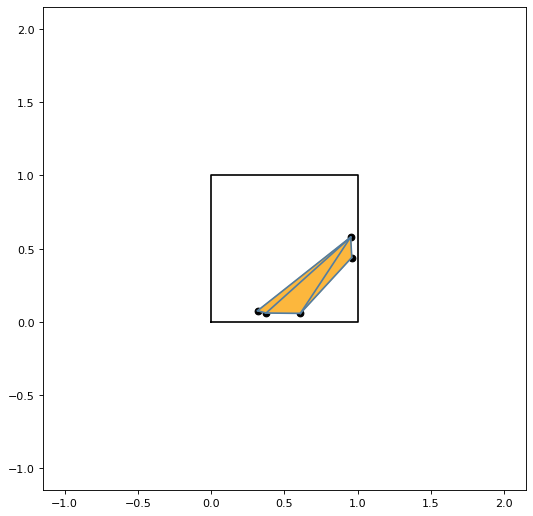

In [211]:
alpha = float('inf')
N = 5

points = gen_points(N=N)
plot_complex(points, alpha=alpha)

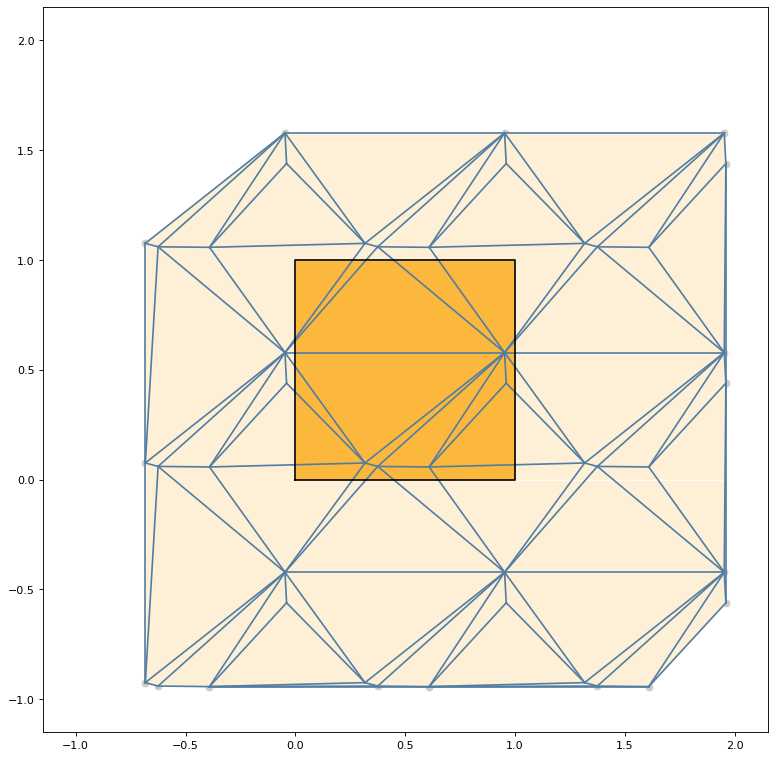

In [212]:
extended_points = torus_copy(points)
plot_complex(extended_points, alpha=alpha, size=12)

Case 2
Case 2


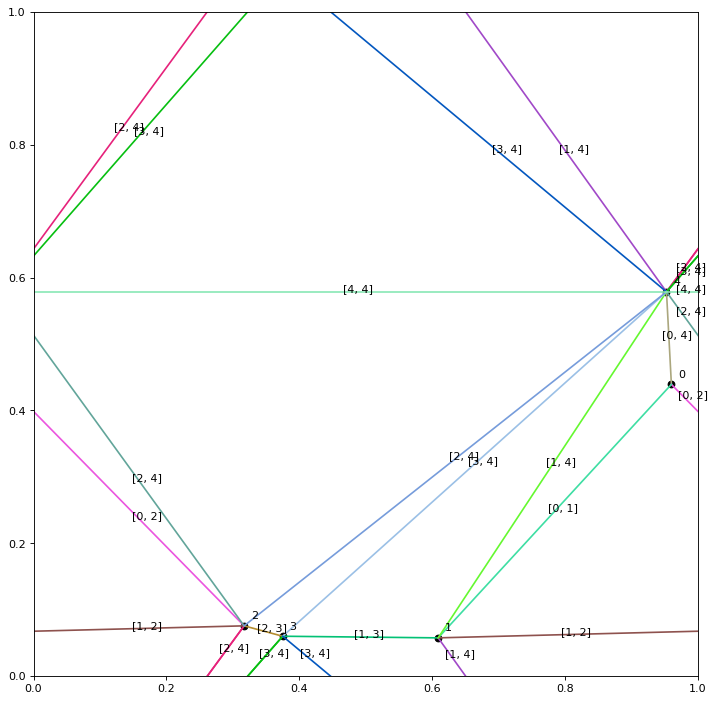

In [221]:
p_filt, coord, crossings = periodic_filtration(N, extended_points, alpha=alpha)

plot_filtration(p_filt, coord, crossings, size=11)

D1, D2, D3 = boundary_matrix(p_filt)
dCn, dZn, dBn, dHn, pp, reps = PH(D1, D2, D3)
pp_cont = disc2cont_pp(pp,p_filt)


In [226]:
for (X,Y,simp,vec) in crossings:
    print(simp,vec)

[2, 3] [0 0]
[0, 4] [0 0]
[1, 3] [0 0]
[0, 2] [1 0]
[0, 1] [0 0]
[1, 4] [ 0 -1]
[2, 4] [1 1]
[3, 4] [1 1]
[1, 2] [1 0]
[1, 4] [0 0]
[3, 4] [0 0]
[3, 4] [ 0 -1]
[2, 4] [1 0]
[2, 4] [0 0]
[4, 4] [1 0]


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

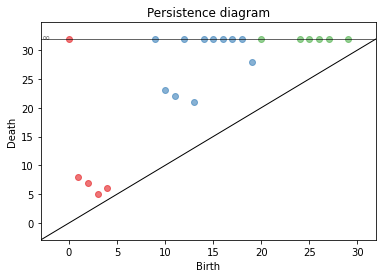

In [222]:
gd.plot_persistence_diagram(pp)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

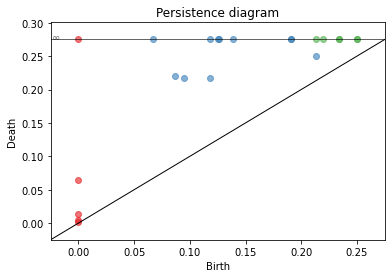

In [218]:
gd.plot_persistence_diagram(pp_cont)


We have a problem.
It probably is somewhere when we calculate the boundary matrix and the pivots.
Originally this has worked fine. 
But now it happens quite often that 
* our persistence is absolutly wrong (does not match torus homology in end-state)
* some simplices are both the birth and the death of a homology element. 

I don't know where precisely this error happens. But I'm pretty sure it got in at some point when we worked in the periodicity, and/or the decision on which simplices to keep when identifying.

I also thing the two problems are closely related. This is because the betti numbers are calculated by counting the number of 0 columns from the pivot-list, and the persistence pairs are also calcualted using the pivot-list, where there is this mentioned inconsistency. 

#### possible solution:
Maybe the problem is that I have the same simplex several times (for example [2,4], but with crossing vectors [1,0] and [0,1]). Have I encoded them as separate simplices, or am I overriting them? Or rather, am I overwriting the old boundary matrix entry, and just have some columns untouched? 